In [1]:
import pandas as pd
print(pd. __version__)
from sklearn.utils import shuffle

#df = pd.read_pickle('https://pandora.infn.it/public/24236c/dl/dataset_pol_vbs_full2018v9_VBS_WW_2j_emu_dnn_ATLAS.pkl')
df = pd.read_pickle('https://pandora.infn.it/public/3dcf6d/dl/dataset_pol_vbs_full2018v9_VBS_WW_2j_emu_dnn_ATLAS_selection.pkl')
pd.set_option('display.max_columns', None)

df['notLL'] = df['isTT'] + df['isMIX']
df['notTT'] = df['isLL'] + df['isMIX']

df_SvB = df[((df['isTT'] + df['isMIX'] + df['isLL']) == 0) & ((df['isVBS'] + df['isBKG']) == 1)]
df_SvB = df_SvB[['CleanJet_pt_1', 'CleanJet_pt_2', 'mll', 'MET_significance', 'zeta', 'mjj', 'detajj', 'dphijj', 'm2ljj30', 'isLL', 'isMIX', 'isTT', 'isBKG', 'isVBS', 'notLL', 'notTT']]
df_red = df[['CleanJet_pt_1', 'CleanJet_pt_2', 'mll', 'MET_significance', 'zeta', 'mjj', 'detajj', 'dphijj', 'm2ljj30', 'isLL', 'isMIX', 'isTT', 'isBKG', 'isVBS', 'notLL', 'notTT']]
df_SvB

1.3.5


,CleanJet_pt_1,CleanJet_pt_2,mll,MET_significance,zeta,mjj,detajj,dphijj,m2ljj30,isLL,isMIX,isTT,isBKG,isVBS,notLL,notTT
0,53.054813,29.876976,119.088409,1.595703,1.021057,276.330872,3.893066,1.000959,271.210632,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,30.664513,29.299437,128.700623,15.085938,2.046753,495.311188,5.605469,1.686401,239.743408,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,30.099604,28.075436,111.508141,10.007812,0.949219,104.640396,2.666260,0.274885,156.898926,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,91.604919,32.597763,267.004730,8.101562,1.380615,551.808350,4.623047,1.564453,840.582458,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,59.228630,48.039818,81.836113,6.886719,1.799194,628.104187,4.930176,1.513550,791.871887,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32287,158.753632,80.266327,85.201508,18.312500,0.529480,1368.427856,4.981445,2.118530,1592.925781,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32288,190.165131,109.592522,112.974281,44.375000,1.710358,1039.798218,3.931885,1.972290,1177.098145,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32289,68.281357,32.656868,129.935699,3.316406,1.657227,903.292419,5.904785,1.004395,1104.163574,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32290,153.700607,113.567513,316.587463,11.273438,0.893066,2401.952637,5.796875,2.201477,3160.002930,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [2]:
import math
import numpy as np
import tensorflow as tf

In [3]:
import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, InputLayer
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
import copy
print(tf.__version__)
from tensorflow.python.client import device_lib
tf.config.run_functions_eagerly(True)

2.7.0-rc1


In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

nclasses = 2
features = df.columns[:len(df.columns)-7]

NDIM = len(features)
print(NDIM)
for col in df.columns:
    df[col]    = np.hstack(df[col])
'''
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df = shuffle(df)
'''
# Perform the splitting and define training and validation datasets
msk    = np.random.rand(len(df_SvB)) < 0.8

df_train    = df_SvB[msk]
df_val      = df_SvB[~msk]

NDIM = len(df_SvB.columns[:len(df_SvB.columns)-7])
X    = df_train.values[:,0:NDIM]
Y    = df_train[['isVBS', 'isBKG']].values
X_val = df_val.values[:,0:NDIM]
Y_val = df_val[['isVBS', 'isBKG']].values

print(X,Y)

59
[[5.30548134e+01 2.98769760e+01 1.19088409e+02 ... 3.89306641e+00
  1.00095880e+00 2.71210632e+02]
 [3.06645126e+01 2.92994366e+01 1.28700623e+02 ... 5.60546875e+00
  1.68640137e+00 2.39743408e+02]
 [3.00996037e+01 2.80754356e+01 1.11508141e+02 ... 2.66625977e+00
  2.74884522e-01 1.56898926e+02]
 ...
 [6.82813568e+01 3.26568680e+01 1.29935699e+02 ... 5.90478516e+00
  1.00439453e+00 1.10416357e+03]
 [1.53700607e+02 1.13567513e+02 3.16587463e+02 ... 5.79687500e+00
  2.20147705e+00 3.16000293e+03]
 [9.00993805e+01 3.42716637e+01 9.79262695e+01 ... 4.00579834e+00
  2.56164551e+00 5.21605835e+02]] [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [5]:
class SimpleNeuralNetwork ( tf.Module ):
    def __init__ (self, nEpochs, learning_rate, N_NODES, n_layers, n_features, n_outputsC=nclasses, ATLAS=False):
        self.learning_rate = learning_rate
        self.optimizer  = tf.optimizers.Adam (self.learning_rate)
        self.nEpochs = nEpochs
        self.N_NODES = N_NODES
        self.n_layers = n_layers
        self.n_features = n_features
        self.n_outputsC = n_outputsC
        self.ATLAS = ATLAS
        self.weights = self.build (self.n_features, self.N_NODES)
        
                                
    # Define the structure of the model
    def build (self, n_input, N_NODES):
        # initializer = initializers.Ones()

        # Classifier model
        self.model1 = Sequential()
        self.model1.add(Dense (self.N_NODES, activation = 'relu', input_dim  = n_input))
        if not self.ATLAS:
            for i in range(self.n_layers):
                self.model1.add(Dense (self.N_NODES, activation = 'relu', kernel_constraint=max_norm(3)))
                self.model1.add(Dropout (0.1))
        else:
            self.model1.add(Dense (108, activation = 'relu', kernel_constraint=max_norm(3)))
            self.model1.add(Dropout (0.1))
            self.model1.add(Dense (60, activation = 'relu', kernel_constraint=max_norm(3)))
            self.model1.add(Dropout (0.1))
        if self.n_outputsC > 1:
            self.model1.add(Dense (self.n_outputsC, activation = 'softmax',input_dim = self.N_NODES))
        else:
            self.model1.add(Dense (self.n_outputsC, activation = 'sigmoid',input_dim = self.N_NODES))
        
        return self.model1.weights
     
    # Performs the epochs loop and the actual training.
    # Monitors the training and validation loss functions, both for the classifier and the adversary.
    # Returns the classifier categorical accuracy.
    def fit (self, X, Y, X_val, Y_val, show_loss = False):
        losses = []
        losses_val = []

        self.means = np.mean ( X, axis = 0)
        self.sigmas = np.std ( X, axis = 0)

        for iEpoch in tqdm.tqdm(range(self.nEpochs)):
                l, l_val = self._train (X, Y, X_val, Y_val)
                losses.append ( l )
                losses_val.append ( l_val )

        losses = np.array(losses)               
        losses_val = np.array(losses_val)
               
        plt.plot (losses, color = "c", label='Training set')
        plt.plot (losses_val, color ='tab:blue', label = "Validation set")
        plt.xlabel ("Epoch"); plt.ylabel ("Loss")
        plt.legend(frameon=False)
        plt.show()
         
        ca = tf.keras.metrics.CategoricalAccuracy()
        if self.n_outputsC <= 1:
            ca = tf.keras.metrics.BinaryAccuracy()
        ca.update_state(Y, self.predict_proba(X))
        
        return ca.result().numpy()

    def save_weights(self, model_name):
        self.model1.save_weights(model_name+'_weights_1')
    
    def load_weights(self, model_name):
        self.model1.load_weights(model_name+'_weights_1')
        
    def save_model(self, model_name):
        self.model1.save("saved_models/"+model_name+"_1")

    def reset_optimizers(self):
        self.optimizer  = tf.optimizers.Adam (self.learning_rate)
        
    def set_epochs(self, epochs):
        self.nEpochs = epochs
        
    # Applies a pre-processing to the input features and returns the classifier representation.
    #@tf.function
    def predict_proba (self, X):
        ppX = (X - self.means)/self.sigmas
        return  tf.clip_by_value ( self.model1 (ppX) , 1e-7, 1. - 1e-7 )


    @tf.function
    def _train (self, X, Y, X_val, Y_val):
        Y_true = tf.cast (Y, tf.float32)
        Y_true_val = tf.cast (Y_val, tf.float32)

        with tf.GradientTape() as gt:
            #gt.watch ( self.weightsC )
            Y_hat = self.predict_proba (X)
            Y_hat_val = self.predict_proba (X_val) #N3(N1(x)) validation set
            
            ## Training set
            # Use the categorical cross-entropy as loss function for the classifier
            cce = 0.
            cce_val = 0.
            bce = 0.
            bce_val = 0.
            loss = 0.
            loss_val = 0.
            
            if self.n_outputsC > 1:
                cce = tf.keras.losses.CategoricalCrossentropy()
                loss = tf.reduce_mean ( cce( Y_true, Y_hat ) )
            
                ## Validation set
                cce_val = tf.keras.losses.CategoricalCrossentropy()
                loss_val = tf.reduce_mean (cce_val( Y_true_val, Y_hat_val ) )
            else:
                bce = tf.keras.losses.BinaryCrossentropy()
                loss = tf.reduce_mean ( bce( Y_true, Y_hat ) )
            
                ## Validation set
                bce_val = tf.keras.losses.BinaryCrossentropy()
                loss_val = tf.reduce_mean (bce_val( Y_true_val, Y_hat_val ) )
            
            # Compute the gradient of the overall loss with respect to the classifier weights
            gradients = gt.gradient ( loss, self.weights )

        # Apply the gradients
        self.optimizer.apply_gradients ( zip(gradients, self.weights) )
        
        return loss, loss_val

In [6]:
dnn = SimpleNeuralNetwork(120, learning_rate=0.001, N_NODES=50, n_layers=8, n_features=X.shape[1], n_outputsC=2, ATLAS=True)
dnn.save_weights("ATLAS_selection_SigVsBkg_emu_RDF")

2023-07-27 08:09:32.231311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-27 08:09:32.240424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-27 08:09:32.241045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-27 08:09:32.242475: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
print(X.shape, Y.shape)
print(X)

(25844, 9) (25844, 2)
[[5.30548134e+01 2.98769760e+01 1.19088409e+02 ... 3.89306641e+00
  1.00095880e+00 2.71210632e+02]
 [3.06645126e+01 2.92994366e+01 1.28700623e+02 ... 5.60546875e+00
  1.68640137e+00 2.39743408e+02]
 [3.00996037e+01 2.80754356e+01 1.11508141e+02 ... 2.66625977e+00
  2.74884522e-01 1.56898926e+02]
 ...
 [6.82813568e+01 3.26568680e+01 1.29935699e+02 ... 5.90478516e+00
  1.00439453e+00 1.10416357e+03]
 [1.53700607e+02 1.13567513e+02 3.16587463e+02 ... 5.79687500e+00
  2.20147705e+00 3.16000293e+03]
 [9.00993805e+01 3.42716637e+01 9.79262695e+01 ... 4.00579834e+00
  2.56164551e+00 5.21605835e+02]]


100%|██████████| 120/120 [00:02<00:00, 44.11it/s]


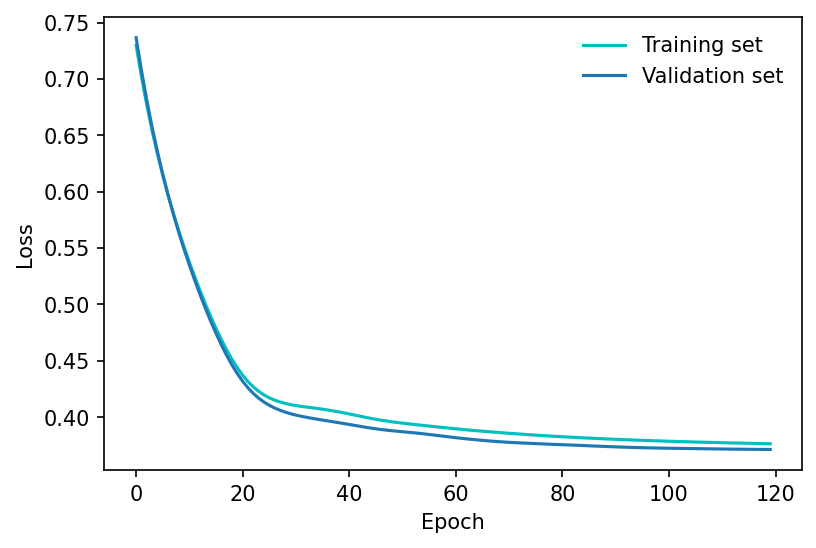

In [8]:
acc = dnn.fit (X.astype(np.float32), Y.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32))

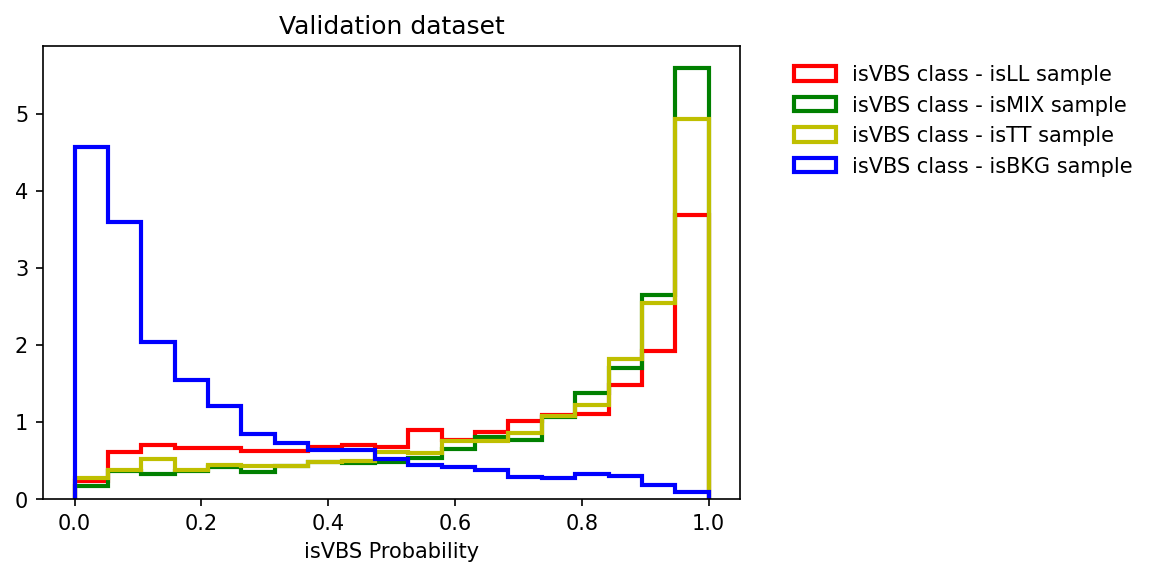

In [9]:
Y_predict_train = dnn.predict_proba(X)
Y_predict_val = dnn.predict_proba(X_val)

axis = np.linspace(0,1,20)

targets = ['isLL', 'isMIX', 'isTT', 'isBKG']
predictions = ['isVBS']
colors = ['r', 'g', 'y', 'b']
 
Y_targets = {}
Y_predictions = {}

for target in targets:
    #Y_targets[target] = dnn.predict_proba( df_val[ df_val[target]==1 ].values[:,0:NDIM] )
    if target != 'isBKG':
        Y_targets[target] = dnn.predict_proba( df_red[ df_red[target]==1 ].values[:,0:NDIM] )
        #Y_targets[target] = dnn.predict_proba( df[ df[target]==1 ].values[:,0:NDIM] )
    else:
        Y_targets[target] = dnn.predict_proba( df_val[ df_val[target]==1 ].values[:,0:NDIM] )
    Y_predictions[target] = {}
    for iprediction, prediction in enumerate(predictions):
        Y_predictions[target][prediction] = Y_targets[target][:,iprediction]

for prediction in predictions:
    for target, mycolor in zip(targets, colors):
        plt.hist(Y_predictions[target][prediction].numpy(), bins = axis, label = prediction + ' class - ' + target + ' sample', histtype='step', color=mycolor,  density=True, linewidth=2 )
    plt.title('Validation dataset')
    plt.xlabel(prediction + ' Probability')
    plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
    #plt.yscale('log')
    plt.show()

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#from matplotlib.backends.backend_pdf import PdfPages

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 16)
    plt.yticks(tick_marks, classes, fontsize = 16)

    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=10)

    plt.xlabel("Predicted label", fontsize=16)
    plt.ylabel("True label", fontsize=16)

    
    plt.tight_layout()

In [11]:
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp, anderson_ksamp

X = df_val.values[:,0:NDIM]
Y_true = df_val[['isVBS', 'isBKG']].values
Y_pred = dnn.predict_proba(X)

# The classifier categorical accuracy is a good and simple metrics to evaluate the overall classification performance
Y_true_max = np.argmax(Y_true, axis=1)
Y_pred_max = np.argmax(Y_pred, axis=1)
print("Classifier categorical accuracy = ", accuracy_score(Y_true_max, Y_pred_max))

Classifier categorical accuracy =  0.8343672456575683


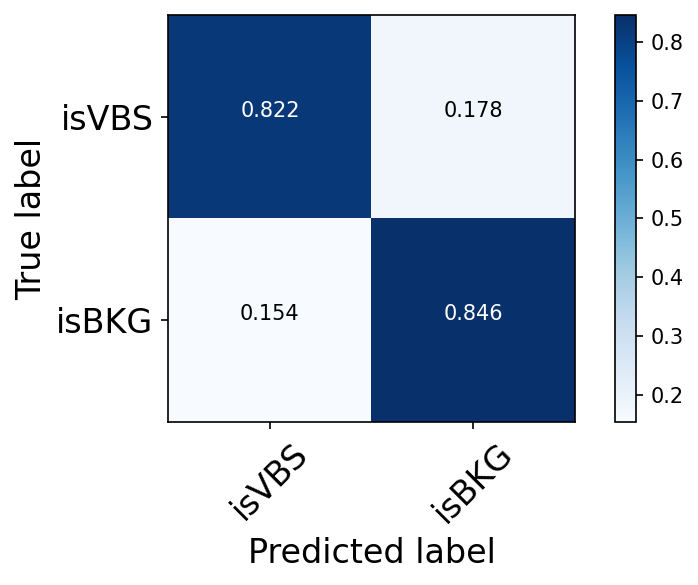

In [12]:
C = confusion_matrix(Y_true_max, Y_pred_max, normalize="true")
C = np.around(C, decimals=3)

plt.figure()
plot_confusion_matrix(C, classes=['isVBS', 'isBKG'], title='')
plt.show(1) 

In [13]:
X    = df_red.values[:,0:NDIM]
print(len(dnn.predict_proba(X)[...,0]))
df['DNN_SigVsBkg'] = dnn.predict_proba(X)[...,0].numpy().tolist()

48438


In [80]:
print(df.columns.values[NDIM:].tolist())
df = df[[col for col in df if col not in df.columns.values[NDIM:].tolist()] + ['DNN_SigVsBkg'] + df.columns.values[NDIM:-1].tolist()]
df

['isLL', 'isMIX', 'isTT', 'isBKG', 'isVBS', 'notLL', 'notTT', 'DNN_SigVsBkg']


,CleanJet_eta_1,CleanJet_eta_2,CleanJet_phi_1,CleanJet_phi_2,CleanJet_pt_1,CleanJet_pt_2,Lepton_eta_1,Lepton_eta_2,Lepton_phi_1,Lepton_phi_2,Lepton_pt_1,Lepton_pt_2,MET_significance,Rpt,Zepp_l1,Zepp_l2,Zepp_ll,detajj,detall,dphijj,dphilep1jet1,dphilep1jet2,dphilep1jj,dphilep2jet1,dphilep2jet2,dphilep2jj,dphill,dphilljet,dphilljetjet,dphillmet,dphilmet1,dphilmet2,dr_l1j1,dr_l1j2,dr_l2j1,dr_l2j2,drll,ht,m2ljj30,mT2,mTi,m_l1j1,m_l1j2,m_l2j1,m_l2j2,mcoll,mcollWW,mjj,mll,mtw1,mtw2,phi_miss,proxyW_l1,proxyW_l2,pt_miss,ptll,recoil,yll,zeta,DNN_SigVsBkg,isLL,isMIX,isTT,isBKG,isVBS,notLL,notTT
0,-1.369629,2.523438,2.955566,-2.326660,53.054813,29.876976,0.719849,-0.348572,0.324402,-0.898926,79.900345,68.976547,1.595703,3.476872,0.142944,-0.925476,0.391266,3.893066,1.068420,1.000959,2.631165,2.651062,2.979963,2.428693,1.427734,2.079895,1.223328,3.091776,2.742978,2.321738,1.761494,2.984821,3.359902,3.206410,3.987439,3.207314,1.624208,268.945618,271.210632,67.454170,220.818268,205.699677,138.472168,130.887726,189.783020,21.942909,178.228348,276.330872,119.088409,112.865700,135.558762,2.085896,125.040550,137.635452,67.013908,122.045883,90.691017,0.221504,1.021057,0.038441,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.438477,-4.166992,0.698364,2.384766,30.664513,29.299437,-0.608276,-1.422363,0.585815,-1.950195,97.959366,38.920242,15.085938,4.243519,0.755981,-0.058105,0.348938,5.605469,0.814087,1.686401,0.112549,1.798950,0.930194,2.648560,1.948224,2.816981,2.536011,0.436593,1.254238,2.441383,2.765428,0.229417,2.049845,3.987566,3.898624,5.130777,2.663473,271.538696,239.743408,138.635910,263.918365,133.487793,319.718811,152.140701,136.750137,27.437832,252.764832,495.311188,128.700623,198.303772,14.563496,-2.179612,207.873352,99.386734,103.994568,69.581612,67.745537,-0.847283,2.046753,0.145060,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.018311,-3.684570,3.027344,-2.980957,30.099604,28.075436,-1.967529,-2.218262,-0.597900,2.771973,67.096413,46.198463,10.007812,3.668086,0.383911,0.133179,0.258545,2.666260,0.250732,0.274885,2.657941,2.383057,2.525311,0.255371,0.530256,0.388001,2.913312,2.216007,2.083377,1.396015,0.954081,2.415792,3.747454,2.937208,1.226824,5.936856,2.924082,203.235275,156.898926,45.883656,258.683807,98.626106,116.712708,49.805935,61.152802,24.233461,264.130157,104.640396,111.508141,58.188202,98.309204,0.356181,156.961578,172.760864,59.840794,24.445000,68.463287,-2.069887,0.949219,0.005695,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-2.482910,2.140137,-2.079590,-0.515137,91.604919,32.597763,-1.102295,0.483093,1.666992,-0.923462,128.451630,81.739906,8.101562,3.516148,-0.930908,0.654480,0.138214,4.623047,1.585388,1.564453,2.536603,2.182129,2.877764,1.156128,0.408325,0.814967,2.590454,3.117462,2.776301,0.852475,0.223355,2.813809,3.992866,3.908331,3.183364,1.706611,3.037089,389.537445,840.582458,59.463200,315.879150,263.529846,335.037811,374.165955,98.272255,191.155640,289.987244,551.808350,267.004730,18.758913,132.475067,1.890347,99.327400,136.463150,55.143219,72.741791,116.669960,-0.457326,1.380615,0.405764,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-3.537109,1.393066,-0.335815,1.177734,59.228630,48.039818,-0.406128,-1.342041,-3.069336,2.493652,81.435837,57.172844,6.886719,1.636335,0.665894,-0.270020,0.197937,4.930176,0.935913,1.513550,2.733521,2.036115,2.891073,2.829468,1.315918,2.170876,0.720197,3.027807,2.596787,2.431972,2.137686,2.857883,4.156342,4.612451,3.581091,3.035202,1.180939,333.340424,791.871887,91.928360,244.596680,345.862061,167.208679,193.272903,203.217087,36.447132,165.542557,628.104187,81.836113,147.970154,140.008194,-0.931650,151.941467,173.332565,87.463287,130.000046,85.432556,-0.797519,1.799194,0.316078,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48433,-3.129395,2.741699,-2.973145,0.735474,89.830719,58.886036,1.100

In [81]:
print(len(df))
print(len(df[(df['DNN_SigVsBkg'] > 0.5) & (df['isBKG'] == 1)]))
print(len(df[(df['DNN_SigVsBkg'] > 0.5) & (df['isLL'] == 1)]))
print(len(df[(df['DNN_SigVsBkg'] > 0.5) & (df['isMIX'] == 1)]))
print(len(df[(df['DNN_SigVsBkg'] > 0.5) & (df['isTT'] == 1)]))

#df_other = df[((df['isTT'] + df['isMIX'] + df['isLL']) == 1) & (df['DNN_SigVsBkg'] > 0.5)]
df_other = df[((df['isTT'] + df['isMIX'] + df['isLL']) == 1) & (df['DNN_SigVsBkg'] > 0.)]

#df_notLL = df_other[df_other['notLL'] == 1].sample(n=int(len(df_other[df_other['notLL'] == 1])/2))
#df_notTT= df_other[df_other['notTT'] == 1].sample(n=int(len(df_other[df_other['notTT'] == 1])/2))

df_notLL = df_other[df_other['notLL'] == 1].sample(n=int(len(df_other[df_other['isLL'] == 1])))
df_notTT= df_other[df_other['notTT'] == 1].sample(n=int(len(df_other[df_other['isTT'] == 1])))


df_LL = pd.concat([df_notLL, df_other[df_other['isLL'] == 1]])
df_TT = pd.concat([df_notTT, df_other[df_other['isTT'] == 1]])

print(len(df_LL[(df_LL['isLL'] == 1)]))
print(len(df_LL[(df_LL['isMIX'] == 1)]))
print(len(df_LL[(df_LL['isTT'] == 1)]))
df_LL

48438
2560
3732
4356
4212
5382
2686
2696


,CleanJet_eta_1,CleanJet_eta_2,CleanJet_phi_1,CleanJet_phi_2,CleanJet_pt_1,CleanJet_pt_2,Lepton_eta_1,Lepton_eta_2,Lepton_phi_1,Lepton_phi_2,Lepton_pt_1,Lepton_pt_2,MET_significance,Rpt,Zepp_l1,Zepp_l2,Zepp_ll,detajj,detall,dphijj,dphilep1jet1,dphilep1jet2,dphilep1jj,dphilep2jet1,dphilep2jet2,dphilep2jj,dphill,dphilljet,dphilljetjet,dphillmet,dphilmet1,dphilmet2,dr_l1j1,dr_l1j2,dr_l2j1,dr_l2j2,drll,ht,m2ljj30,mT2,mTi,m_l1j1,m_l1j2,m_l2j1,m_l2j2,mcoll,mcollWW,mjj,mll,mtw1,mtw2,phi_miss,proxyW_l1,proxyW_l2,pt_miss,ptll,recoil,yll,zeta,DNN_SigVsBkg,isLL,isMIX,isTT,isBKG,isVBS,notLL,notTT
40518,-0.477417,2.986816,1.836426,-1.672363,124.805344,80.120354,0.226135,2.252441,0.036774,2.776367,84.481834,64.644058,13.671875,0.546155,-1.028564,0.997742,0.015411,3.464233,2.026306,2.774396,1.799652,1.709137,2.321460,0.939941,1.834455,0.418133,2.739594,1.008260,1.530068,2.142135,1.350743,2.192849,1.932287,3.246923,2.887147,4.508936,3.407534,437.157532,815.015503,3.160135e+01,348.510468,177.942291,330.811035,339.706390,127.020271,126.127602,205.137039,583.159729,228.474884,104.770233,130.405304,-1.313969,106.477066,240.668655,83.105957,35.556599,70.533859,1.136892,0.703552,0.698907,0.0,1.0,0.0,0.0,1.0,1.0,1.0
44449,1.980225,-3.985840,2.588867,1.987793,193.126358,54.814369,-0.160583,1.335205,-1.342529,1.149414,266.018677,31.155691,116.187500,0.782913,0.842224,2.338013,1.590118,5.966064,1.495789,0.601074,2.351789,2.952863,2.481129,1.439453,0.838379,1.310113,2.491943,2.429763,2.559103,1.907331,1.985305,0.506638,4.476487,5.071847,1.577363,5.386687,2.906401,692.228027,2395.236816,2.388153e+02,416.484070,718.230225,835.173340,115.836853,589.225464,455.491150,484.218079,2027.787598,228.132904,331.348602,33.934185,0.642776,332.871216,103.010315,147.112946,241.944656,238.059662,0.036701,0.645020,0.878863,0.0,0.0,1.0,0.0,1.0,1.0,0.0
39659,-3.074219,2.674805,1.145020,0.401611,95.718979,39.599072,-1.658447,-0.592651,-2.795410,-1.236084,66.873520,52.486717,3.103516,0.926020,-1.458740,-0.392944,0.925842,5.749023,1.065796,0.743408,2.342756,3.086164,2.554176,2.381104,1.637695,2.169683,1.559326,3.003820,3.067945,0.003075,0.664139,0.895187,4.187051,5.384981,3.439161,3.654903,1.888761,316.240601,1250.063110,4.807276e+01,175.575394,192.404648,455.175323,260.644897,234.469772,183.966873,257.434845,1088.404053,106.388313,41.834286,49.203587,-2.131271,126.169441,59.912575,61.562298,85.483574,147.045700,-1.184388,1.415771,0.428050,0.0,1.0,0.0,0.0,1.0,1.0,1.0
39627,3.229492,-1.982422,2.911621,0.068192,171.464676,26.969557,-1.343262,2.045410,-0.316284,-1.466553,155.979950,38.758762,9.328125,1.307345,-1.966797,1.421875,0.272461,5.211914,3.388672,2.843430,3.055280,0.384476,3.109609,1.905012,1.534744,1.959340,1.150269,2.852175,2.906504,1.929827,1.726722,2.876991,5.597272,0.745887,4.535467,4.310321,3.578577,432.700623,1686.925415,8.678886e+01,495.263245,1625.792969,50.484715,168.873550,242.322266,326.821198,373.291901,926.510620,417.585999,154.809525,100.647934,1.410438,213.705505,158.863327,66.497269,175.408432,164.296051,-0.285602,0.639160,0.869667,0.0,1.0,0.0,0.0,1.0,1.0,1.0
41551,1.042725,-4.070312,-2.477051,-0.161530,181.452820,71.989296,-1.866943,0.174805,1.780273,0.376526,95.604736,57.316761,7.296875,0.419498,-0.353149,1.688599,0.667725,5.113037,2.041748,2.315521,2.025861,1.941803,2.405507,2.853577,0.538055,2.473931,1.403748,2.519122,2.898768,0.656762,1.150023,0.253725,5.156644,2.936909,2.982647,4.279080,2.477749,508.310608,1724.230713,3.882069e+01,313.446869,580.387268,261.430328,224.522217,530.164307,400.757690,439.905487,1482.520996,202.744644,107.382027,19.343044,0.630250,237.887344,23.519346,101.947006,119.363922,209.560638,-1.041360,0.867920,0.935274,0.0,1.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37669,2.833984

In [82]:
for col in df.columns:
    df_LL[col] = np.hstack(df_LL[col])
    df_TT[col] = np.hstack(df_TT[col])
'''
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df = shuffle(df)
'''
# Perform the splitting and define training and validation datasets
msk_LL = np.random.rand(len(df_LL)) < 0.8
msk_TT = np.random.rand(len(df_TT)) < 0.8

df_train_LL = df_LL[msk_LL]
df_train_TT = df_TT[msk_TT]
df_val_LL   = df_LL[~msk_LL]
df_val_TT   = df_TT[~msk_TT]

features = df_LL.columns[:len(df.columns)-7]
NDIM = len(features)

X_LL = df_train_LL.values[:,0:NDIM]
Y_LL = df_train_LL[['isLL', 'notLL']].values
#Y_LL = df_train_LL[['isLL']].values
X_val_LL = df_val_LL.values[:,0:NDIM]
Y_val_LL = df_val_LL[['isLL', 'notLL']].values
#Y_val_LL = df_val_LL[['isLL']].values

X_TT = df_train_TT.values[:,0:NDIM]
Y_TT = df_train_TT[['isTT', 'notTT']].values
#Y_TT = df_train_TT[['isTT']].values
X_val_TT = df_val_TT.values[:,0:NDIM]
Y_val_TT = df_val_TT[['isTT', 'notTT']].values
#Y_val_TT = df_val_TT[['isTT']].values

#X_val = df_val.values[:,0:NDIM+1]
#Y_val = df_val.values[:,NDIM+1:NDIM+1+nclasses] # isLL, isMIX, isTT, isBKG
print(X_LL,Y_LL)

[[-0.47741699  2.98681641  1.83642578 ...  1.13689184  0.70355225
   0.69890678]
 [ 1.98022461 -3.98583984  2.58886719 ...  0.03670105  0.64501953
   0.87886256]
 [-3.07421875  2.67480469  1.14501953 ... -1.18438804  1.41577148
   0.42805037]
 ...
 [ 1.23266602 -3.45507812 -1.70776367 ... -0.47353783  1.15490723
   0.963875  ]
 [ 3.66943359 -1.52026367 -2.64892578 ...  1.21604979  1.39453125
   0.26993981]
 [-3.26123047  1.88598633  2.27099609 ... -0.64441437  1.29846191
   0.962174  ]] [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [95]:
dnnLL = SimpleNeuralNetwork(250, learning_rate=0.0001, N_NODES=50, n_layers=8, n_features=X_LL.shape[1], n_outputsC=2, ATLAS=False)
dnnLL.save_weights("ATLAS_selection_LLvsOther_emu_RDF")

In [96]:
print(X_LL.shape, Y_LL.shape)

(8637, 60) (8637, 2)


100%|██████████| 250/250 [00:08<00:00, 30.95it/s]


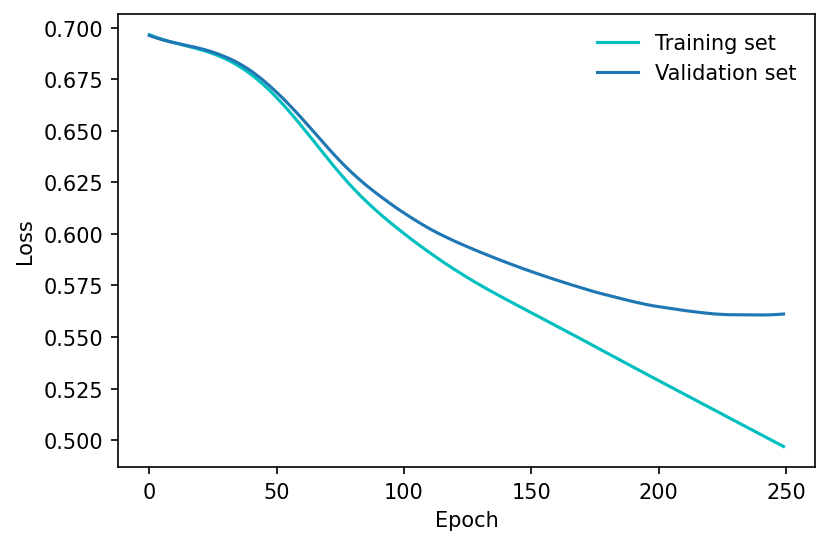

In [97]:
acc = dnnLL.fit (X_LL.astype(np.float32), Y_LL.astype(np.float32), X_val_LL.astype(np.float32), Y_val_LL.astype(np.float32))

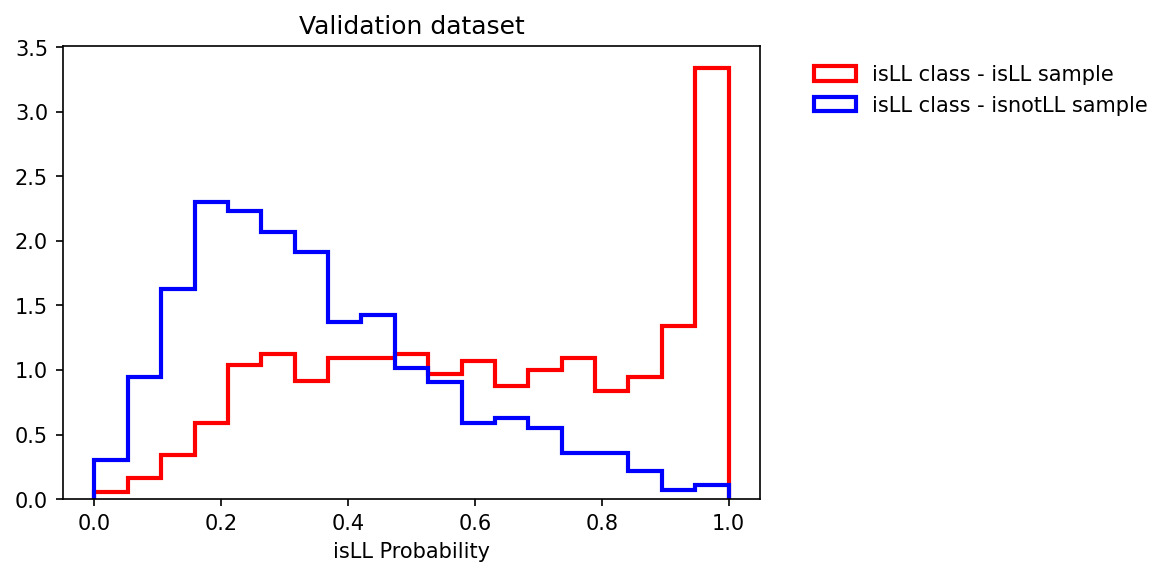

In [98]:
Y_predict_train_LL = dnnLL.predict_proba(X_LL)
Y_predict_val_LL = dnnLL.predict_proba(X_val_LL)

axis = np.linspace(0,1,20)

plt.hist(dnnLL.predict_proba( df_val_LL[ df_val_LL['isLL']==1 ].values[:,0:NDIM] ).numpy()[...,0], bins = axis, label = 'isLL class - isLL sample', histtype='step', color='r',  density=True, linewidth=2 )
plt.hist(dnnLL.predict_proba( df_val_LL[ df_val_LL['isLL']==0 ].values[:,0:NDIM] ).numpy()[...,0], bins = axis, label = 'isLL class - isnotLL sample', histtype='step', color='b',  density=True, linewidth=2 )
plt.title('Validation dataset')
plt.xlabel('isLL Probability')
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
#plt.yscale('log')
plt.show()

In [99]:
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp, anderson_ksamp

X_LL = df_val_LL.values[:,0:NDIM]
Y_true_LL = df_val_LL[['isLL', 'notLL']].values
Y_pred_LL = dnnLL.predict_proba(X_LL)

# The classifier categorical accuracy is a good and simple metrics to evaluate the overall classification performance
Y_true_max_LL = np.argmax(Y_true_LL, axis=1)
Y_pred_max_LL = np.argmax(Y_pred_LL, axis=1)
print("Classifier categorical accuracy = ", accuracy_score(Y_true_max_LL, Y_pred_max_LL))

Classifier categorical accuracy =  0.7005171603196991


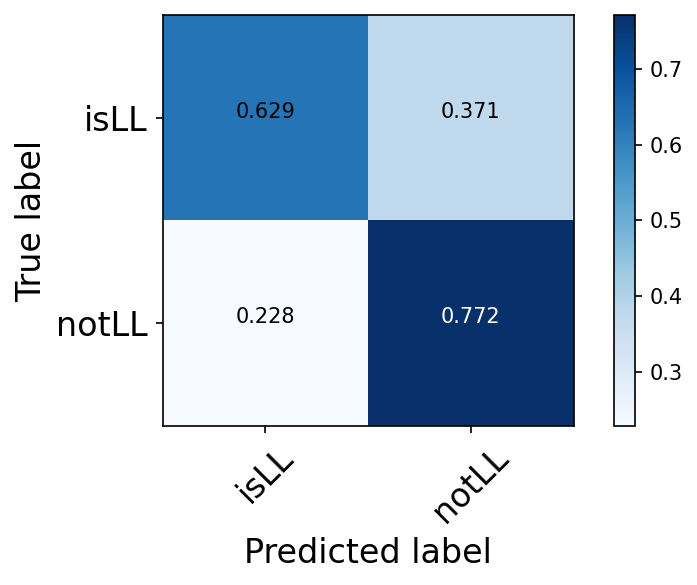

In [100]:
C = confusion_matrix(Y_true_max_LL, Y_pred_max_LL, normalize="true")
C = np.around(C, decimals=3)

plt.figure()
plot_confusion_matrix(C, classes=['isLL', 'notLL'], title='')
plt.show(1) 

In [105]:
dnnTT = SimpleNeuralNetwork(200, learning_rate=0.0001, N_NODES=50, n_layers=8, n_features=X_TT.shape[1], n_outputsC=2, ATLAS=False)
dnnTT.save_weights("ATLAS_selection_TTvsOther_emu_RDF")

100%|██████████| 200/200 [00:06<00:00, 29.83it/s]


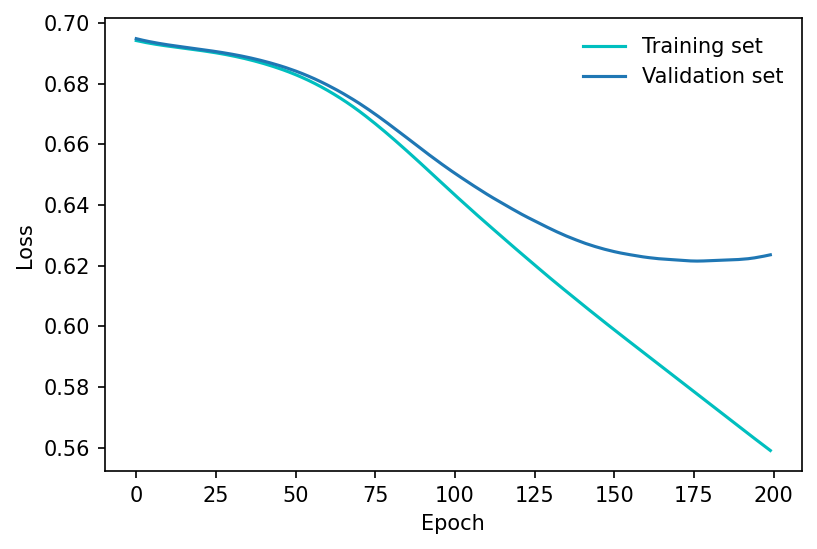

In [106]:
acc = dnnTT.fit (X_TT.astype(np.float32), Y_TT.astype(np.float32), X_val_TT.astype(np.float32), Y_val_TT.astype(np.float32))

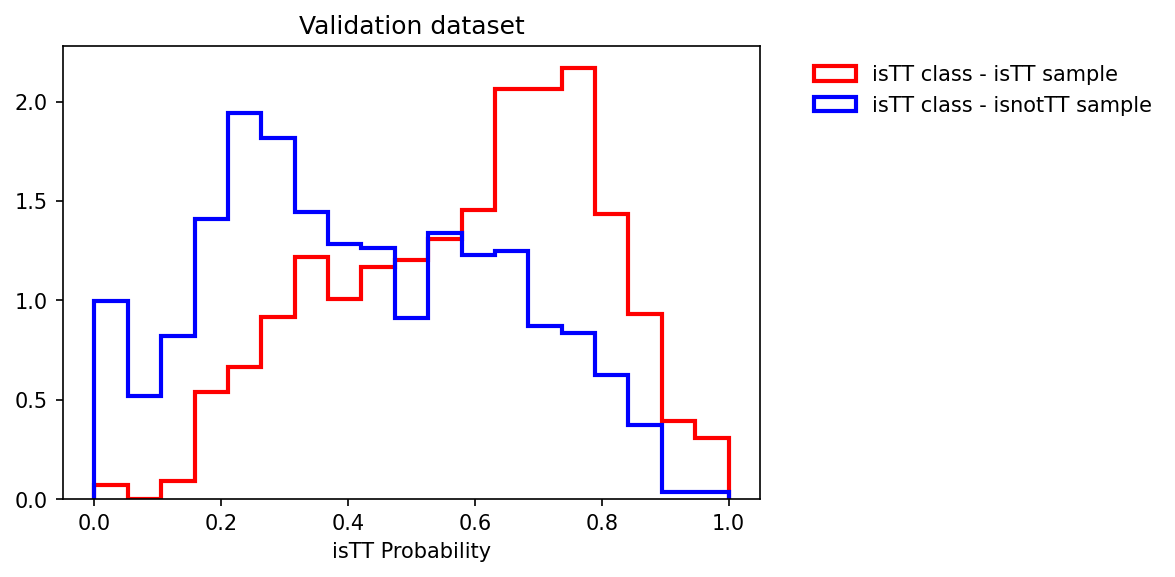

In [107]:
Y_predict_train_TT = dnnTT.predict_proba(X_TT)
Y_predict_val_TT = dnnTT.predict_proba(X_val_TT)

axis = np.linspace(0,1,20)

plt.hist(dnnTT.predict_proba( df_val_TT[ df_val_TT['isTT']==1 ].values[:,0:NDIM] ).numpy()[...,0], bins = axis, label = 'isTT class - isTT sample', histtype='step', color='r',  density=True, linewidth=2 )
plt.hist(dnnTT.predict_proba( df_val_TT[ df_val_TT['isTT']==0 ].values[:,0:NDIM] ).numpy()[...,0], bins = axis, label = 'isTT class - isnotTT sample', histtype='step', color='b',  density=True, linewidth=2 )
plt.title('Validation dataset')
plt.xlabel('isTT Probability')
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
#plt.yscale('log')
plt.show()

In [229]:
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp, anderson_ksamp

X_TT = df_val_TT.values[:,0:NDIM]
Y_true_TT = df_val_TT[['isTT', 'notTT']].values
Y_pred_TT = dnnTT.predict_proba(X_TT)

# The classifier categorical accuracy is a good and simple metrics to evaluate the overall classification performance
Y_true_max_TT = np.argmax(Y_true_TT, axis=1)
Y_pred_max_TT = np.argmax(Y_pred_TT, axis=1)
print("Classifier categorical accuracy = ", accuracy_score(Y_true_max_TT, Y_pred_max_TT))

Classifier categorical accuracy =  0.6825876662636033


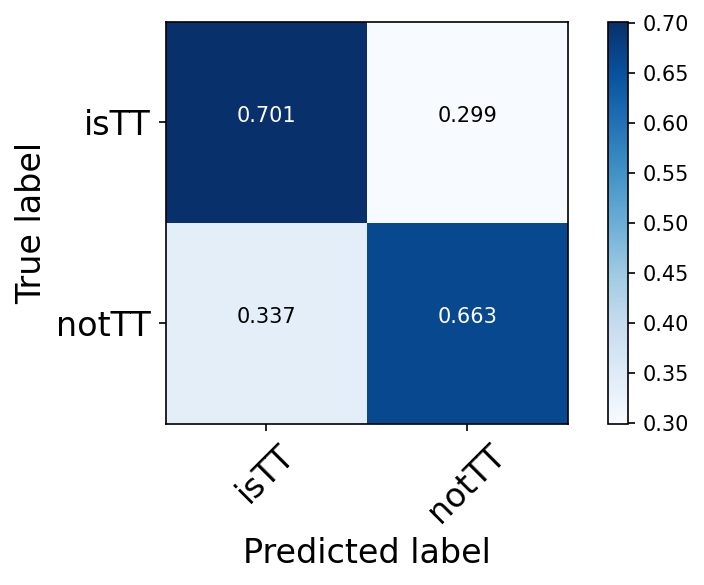

In [230]:
C = confusion_matrix(Y_true_max_TT, Y_pred_max_TT, normalize="true")
C = np.around(C, decimals=3)

plt.figure()
plot_confusion_matrix(C, classes=['isTT', 'notTT'], title='')
plt.show(1) 

In [231]:
print(len(dnnLL.predict_proba(X_val_LL)[...,0]))
print(len(dnnTT.predict_proba(X_val_LL)[...,0]))
df_val_LL['DNN_LL'] = dnnLL.predict_proba(X_val_LL)[...,0].numpy().tolist()
df_val_LL['DNN_TT'] = dnnTT.predict_proba(X_val_LL)[...,0].numpy().tolist()
df_val_bkg = df[(df['DNN_SigVsBkg'] > 0.5) & (df['isBKG'] == 1)]
X_val_bkg = df_val_bkg.values[:,0:NDIM]
df_val_bkg['DNN_LL'] = dnnLL.predict_proba(X_val_bkg)[...,0].numpy().tolist()
df_val_bkg['DNN_TT'] = dnnTT.predict_proba(X_val_bkg)[...,0].numpy().tolist()
print(df_val_LL)
print(df_val_bkg)

1608
1608
       CleanJet_eta_1  CleanJet_eta_2  CleanJet_phi_1  CleanJet_phi_2  \
44665        0.937134       -4.084961        2.667969       -1.143555   
41650       -2.507324        1.450439       -0.121002        3.026367   
41627        1.963623       -2.478516       -1.513428        2.435059   
42323        0.155762        4.254883        2.935547       -2.021973   
47697       -2.166016        3.692871        1.979248       -2.877930   
...               ...             ...             ...             ...   
37641        4.244141       -4.335938        0.567749       -0.154175   
37642        3.259277       -1.629883        1.904541       -0.386963   
37646        2.483887       -2.088867       -1.333008        1.924072   
37648       -4.634766        4.043945       -2.001953       -2.539062   
37673       -3.261230        1.885986        2.270996       -1.406006   

       CleanJet_pt_1  CleanJet_pt_2  Lepton_eta_1  Lepton_eta_2  Lepton_phi_1  \
44665     122.242439      71.023

/tmp/ipykernel_257/3038950175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_LL['DNN_LL'] = dnnLL.predict_proba(X_val_LL)[...,0].numpy().tolist()
/tmp/ipykernel_257/3038950175.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_LL['DNN_TT'] = dnnTT.predict_proba(X_val_LL)[...,0].numpy().tolist()
/tmp/ipykernel_257/3038950175.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

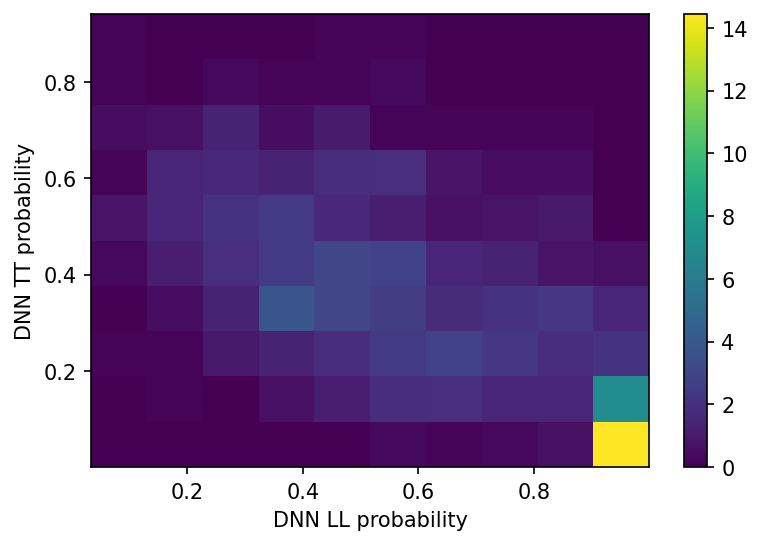

In [232]:
LL = df_val_LL[df_val_LL['isLL'] == 1]
mix = df_val_LL[df_val_LL['isMIX'] == 1]
TT = df_val_LL[df_val_LL['isTT'] == 1]

fig, ax = plt.subplots()
h_isLL = ax.hist2d(LL['DNN_LL'].values, LL['DNN_TT'].values, density=True)
fig.colorbar(h_isLL[3], ax=ax)
plt.ylabel('DNN TT probability')
plt.xlabel('DNN LL probability')
plt.show()

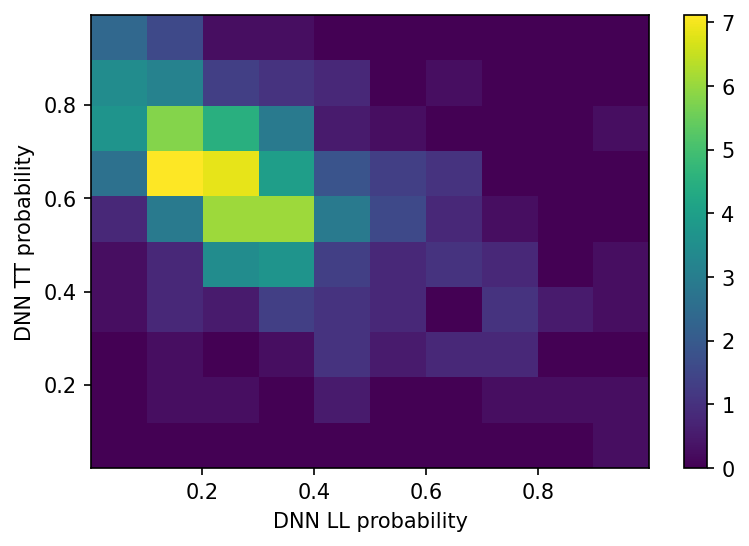

In [233]:
fig, ax = plt.subplots()
h_isTT = ax.hist2d(TT['DNN_LL'].values, TT['DNN_TT'].values, density=True)
fig.colorbar(h_isTT[3], ax=ax)
plt.ylabel('DNN TT probability')
plt.xlabel('DNN LL probability')
plt.show()

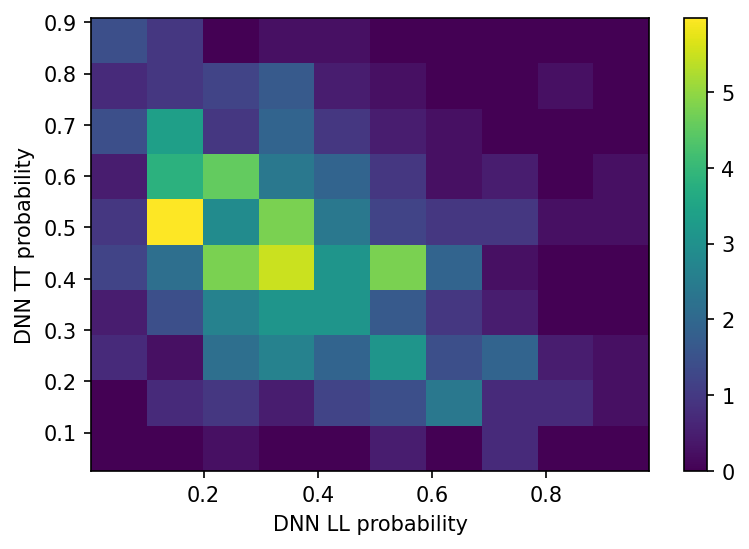

In [234]:
fig, ax = plt.subplots()
h_isMIX = ax.hist2d(mix['DNN_LL'].values, mix['DNN_TT'].values, density=True)
fig.colorbar(h_isMIX[3], ax=ax)
plt.ylabel('DNN TT probability')
plt.xlabel('DNN LL probability')
plt.show()

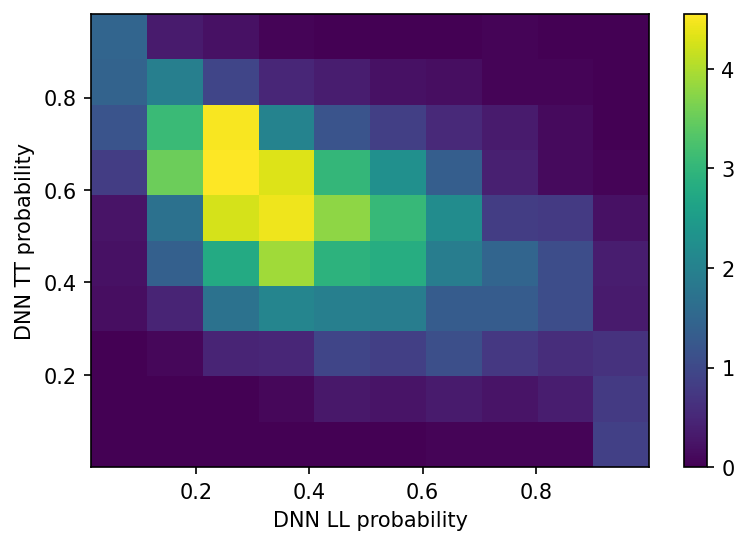

In [235]:
fig, ax = plt.subplots()
h_isBKG = ax.hist2d(df_val_bkg['DNN_LL'].values, df_val_bkg['DNN_TT'].values, density=True)
fig.colorbar(h_isBKG[3], ax=ax)
plt.ylabel('DNN TT probability')
plt.xlabel('DNN LL probability')
plt.show()

/tmp/ipykernel_257/3595125263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_TT['DNN_LL'] = dnnLL.predict_proba(X_val_TT)[...,0].numpy().tolist()
/tmp/ipykernel_257/3595125263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_TT['DNN_TT'] = dnnTT.predict_proba(X_val_TT)[...,0].numpy().tolist()


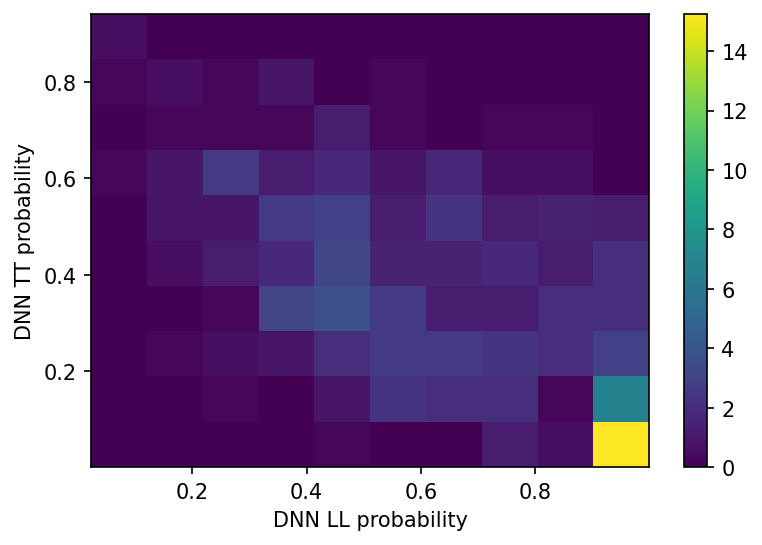

In [236]:
df_val_TT['DNN_LL'] = dnnLL.predict_proba(X_val_TT)[...,0].numpy().tolist()
df_val_TT['DNN_TT'] = dnnTT.predict_proba(X_val_TT)[...,0].numpy().tolist()

LL = df_val_TT[df_val_TT['isLL'] == 1]
mix = df_val_TT[df_val_TT['isMIX'] == 1]
TT = df_val_TT[df_val_TT['isTT'] == 1]

fig, ax = plt.subplots()
h_isLL = ax.hist2d(LL['DNN_LL'].values, LL['DNN_TT'].values, density=True)
fig.colorbar(h_isLL[3], ax=ax)
plt.ylabel('DNN TT probability')
plt.xlabel('DNN LL probability')
plt.show()

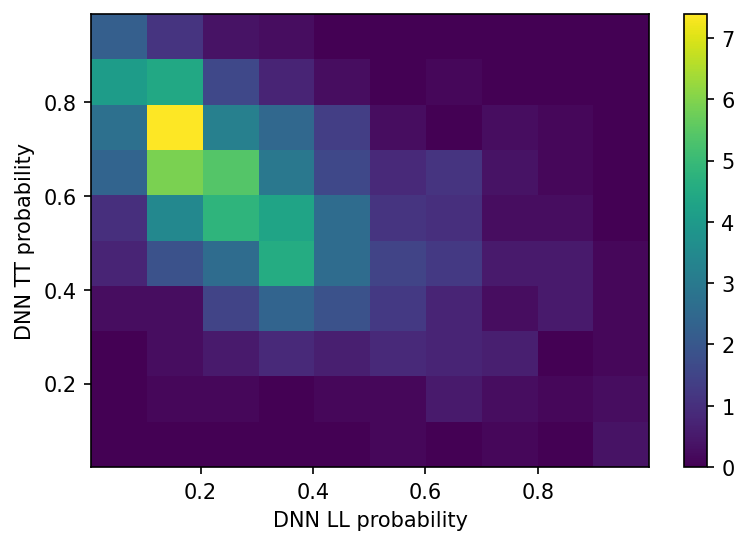

In [237]:
fig, ax = plt.subplots()
h_isTT = ax.hist2d(TT['DNN_LL'].values, TT['DNN_TT'].values, density=True)
fig.colorbar(h_isTT[3], ax=ax)
plt.ylabel('DNN TT probability')
plt.xlabel('DNN LL probability')
plt.show()

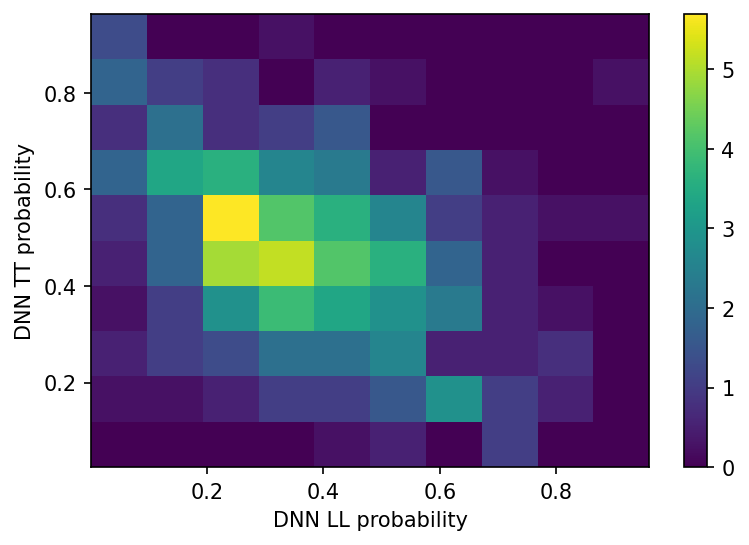

In [238]:
fig, ax = plt.subplots()
h_isMIX = ax.hist2d(mix['DNN_LL'].values, mix['DNN_TT'].values, density=True)
fig.colorbar(h_isMIX[3], ax=ax)
plt.ylabel('DNN TT probability')
plt.xlabel('DNN LL probability')
plt.show()

In [36]:
with open('generated_code_dnn_SigVsBkg_emu.h', 'w') as f:


    print ("""
    // Select all (Ctrl+A), Copy (Ctrl+C), paste to an empty text file (Ctrl+V) and save that file as 'generated_code.h'
    // 
    // Auto-generated header file. Assumes img to be a floating point array
    // of 64 elements (corresponding to an 8x8 b&w image)

    #include <math.h>

    float norma_VBS;
    """, file=f)
    
    iLayer_tmp=-1

    for iLayer, layer in enumerate(dnn.model1.layers):
      print(type(layer))
#       if type(layer) is not Dropout and type(layer) is not Input :
      if type(layer) is Dense:
        kernel, bias = layer.get_weights()
        iLayer_tmp+=1
        print ("inline float activation_VBS_%d (float x, float n) " % iLayer_tmp, file=f);
        activation =  layer.get_config()['activation'] 
        if activation == 'sigmoid':
          print ("{ return 1./(1 + exp(-x)); }", file=f)
        elif activation == 'tanh':
          print ("{ return tanh(x);}")
        elif activation == 'relu':
          print ("{ return x > 0 ? x : 0;}", file=f)
        elif activation == 'linear':
          print ("{ return x;}")
        elif activation == 'softmax':
          print ("{ return exp(x)/n;  }", file=f)
        else:
          raise KeyError ("Unexpected activation %s"%activation)
      
    iLayer_tmp=-1

    
    print ("""
    float guess_VBS (const float *img, int flag)
    {
    """, file=f)

    max_out = 100
    for iLayer, layer in enumerate(dnn.model1.layers):
      if type(layer) is Dense:
        iLayer_tmp+=1
        print ("  // Declare the arrays in the stack", file=f)
        kernel, bias = layer.get_weights()
        
        print (type (dnn.means))
        print (type(bias))
        
         
        max_out = max(kernel.shape[1], max_out)
        #print ("  //",bias.shape)
        kernel_values = "{%s}"%(',\n   '.join(["{%s}"%(','.join(["%18.13f"%x for x in row])) for row in kernel]))
        bias_values   = "{%s}"% ( ",".join(["%18.13f"%x for x in bias]))
        print ("  const float kernel_%d[%d][%d] = \n  %s;" % (iLayer_tmp, kernel.shape[0], kernel.shape[1],kernel_values), file=f)
        print ("  const float bias_%d[%d] = %s;" % (iLayer_tmp, bias.shape[0], bias_values), file=f)
      
    print ("  float buffer_in[%d];" % max_out, file=f)
    print ("  float buffer_out[%d];" % max_out, file=f)

    print ("  unsigned int i,j,c; ", file=f)
    

    mean_values = "{%s}"% ( ",".join(["%18.13f"%x for x in dnn.means]))
    sigma_values = "{%s}"% ( ",".join(["%18.13f"%x for x in dnn.sigmas]))
    

    print (" float mean[%d] = %s;" % (max_out, mean_values), file=f)
    print (" float sigma[%d] = %s;" % (max_out, sigma_values), file=f)

    print ("\n\n\n", file=f)
    print ("  // Load the input in the buffer", file=f)
    print ("  for (c = 0; c < 64; ++c) \n  buffer_in[c] = (img[c]-mean[c])/sigma[c];", file=f)



    iLayer_tmp=-1

    for iLayer, layer in enumerate(dnn.model1.layers):
      if type(layer) is Dense: 
        kernel, bias = layer.get_weights()
        iLayer_tmp+=1

        if iLayer != len(dnn.model1.layers)-1:
            
            
            print ( "  // Processing layer %i " % iLayer_tmp , file=f)
            print ( """
            for (c = 0; c < {n_out}; ++c ) 
              buffer_out[c] = bias_{iLayer_tmp}[c];

            for (c = 0; c < {n_out}; ++c )
              for (i = 0; i < {n_in}; ++i)
                buffer_out[c] += buffer_in[i] * kernel_{iLayer_tmp}[i][c];

            norma_VBS = 0;

            // Prepares for next layer 
            for (c = 0; c < {n_out}; ++c )
              buffer_in[c] = activation_VBS_{iLayer_tmp}(buffer_out[c], norma_VBS);


            """.format (
                n_in = kernel.shape[0],
                n_out = kernel.shape[1],
                iLayer_tmp = iLayer_tmp,
            ), file=f)
            
        else:
            
            print ( "  // Processing layer %i " % iLayer_tmp , file=f)
            print ( """
            for (c = 0; c < {n_out}; ++c ) 
              buffer_out[c] = bias_{iLayer_tmp}[c];

            for (c = 0; c < {n_out}; ++c )
              for (i = 0; i < {n_in}; ++i)
                buffer_out[c] += buffer_in[i] * kernel_{iLayer_tmp}[i][c];

            norma_VBS = 0;

            for(c=0;c<{n_out};++c)
              norma_VBS+=exp(buffer_out[c]);

            // Prepares for next layer 
            for (c = 0; c < {n_out}; ++c )
              buffer_in[c] = activation_VBS_{iLayer_tmp}(buffer_out[c], norma_VBS);


            """.format (
                n_in = kernel.shape[0],
                n_out = kernel.shape[1],
                iLayer_tmp = iLayer_tmp,
            ), file=f)
      
    last_kernel, last_bias = dnn.model1.layers[-1].get_weights()
    print ("""
      //i = 0;
      //for (c = 0; c < {n_out}; ++c)
      //  if (buffer_in[c] > buffer_in[i])
      //    i = c;
      
      if (flag==0) //vbf
        return buffer_in[0];
      else if (flag==1) //bkg
        return buffer_in[1];
         
      
      //return i;
    """.format(n_out = last_kernel.shape[1]), file=f)

    print ("}", file=f)

<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [37]:
with open('generated_code_dnn_emu_LLVsOther.h', 'w') as f:


    print ("""
    // Select all (Ctrl+A), Copy (Ctrl+C), paste to an empty text file (Ctrl+V) and save that file as 'generated_code.h'
    // 
    // Auto-generated header file. Assumes img to be a floating point array
    // of 64 elements (corresponding to an 8x8 b&w image)

    #include <math.h>

    float norma_LL;
    """, file=f)
    
    iLayer_tmp=-1

    for iLayer, layer in enumerate(dnnLL.model1.layers):
      print(type(layer))
#       if type(layer) is not Dropout and type(layer) is not Input :
      if type(layer) is Dense:
        kernel, bias = layer.get_weights()
        iLayer_tmp+=1
        print ("inline float activation_LL_%d (float x, float n) " % iLayer_tmp, file=f);
        activation =  layer.get_config()['activation'] 
        if activation == 'sigmoid':
          print ("{ return 1./(1 + exp(-x)); }", file=f)
        elif activation == 'tanh':
          print ("{ return tanh(x);}")
        elif activation == 'relu':
          print ("{ return x > 0 ? x : 0;}", file=f)
        elif activation == 'linear':
          print ("{ return x;}")
        elif activation == 'softmax':
          print ("{ return exp(x)/n;  }", file=f)
        else:
          raise KeyError ("Unexpected activation %s"%activation)
      
    iLayer_tmp=-1

    
    print ("""
    float guess_LL (const float *img, int flag)
    {
    """, file=f)

    max_out = 100
    for iLayer, layer in enumerate(dnnLL.model1.layers):
      if type(layer) is Dense:
        iLayer_tmp+=1
        print ("  // Declare the arrays in the stack", file=f)
        kernel, bias = layer.get_weights()
        
        print (type (dnnLL.means))
        print (type(bias))
        
         
        max_out = max(kernel.shape[1], max_out)
        #print ("  //",bias.shape)
        kernel_values = "{%s}"%(',\n   '.join(["{%s}"%(','.join(["%18.13f"%x for x in row])) for row in kernel]))
        bias_values   = "{%s}"% ( ",".join(["%18.13f"%x for x in bias]))
        print ("  const float kernel_%d[%d][%d] = \n  %s;" % (iLayer_tmp, kernel.shape[0], kernel.shape[1],kernel_values), file=f)
        print ("  const float bias_%d[%d] = %s;" % (iLayer_tmp, bias.shape[0], bias_values), file=f)
      
    print ("  float buffer_in[%d];" % max_out, file=f)
    print ("  float buffer_out[%d];" % max_out, file=f)

    print ("  unsigned int i,j,c; ", file=f)
    

    mean_values = "{%s}"% ( ",".join(["%18.13f"%x for x in dnnLL.means]))
    sigma_values = "{%s}"% ( ",".join(["%18.13f"%x for x in dnnLL.sigmas]))
    

    print (" float mean[%d] = %s;" % (max_out, mean_values), file=f)
    print (" float sigma[%d] = %s;" % (max_out, sigma_values), file=f)

    print ("\n\n\n", file=f)
    print ("  // Load the input in the buffer", file=f)
    print ("  for (c = 0; c < 64; ++c) \n  buffer_in[c] = (img[c]-mean[c])/sigma[c];", file=f)



    iLayer_tmp=-1

    for iLayer, layer in enumerate(dnnLL.model1.layers):
      if type(layer) is Dense: 
        kernel, bias = layer.get_weights()
        iLayer_tmp+=1

        if iLayer != len(dnnLL.model1.layers)-1:
            
            
            print ( "  // Processing layer %i " % iLayer_tmp , file=f)
            print ( """
            for (c = 0; c < {n_out}; ++c ) 
              buffer_out[c] = bias_{iLayer_tmp}[c];

            for (c = 0; c < {n_out}; ++c )
              for (i = 0; i < {n_in}; ++i)
                buffer_out[c] += buffer_in[i] * kernel_{iLayer_tmp}[i][c];

            norma_LL = 0;

            // Prepares for next layer 
            for (c = 0; c < {n_out}; ++c )
              buffer_in[c] = activation_LL_{iLayer_tmp}(buffer_out[c], norma_LL);


            """.format (
                n_in = kernel.shape[0],
                n_out = kernel.shape[1],
                iLayer_tmp = iLayer_tmp,
            ), file=f)
            
        else:
            
            print ( "  // Processing layer %i " % iLayer_tmp , file=f)
            print ( """
            for (c = 0; c < {n_out}; ++c ) 
              buffer_out[c] = bias_{iLayer_tmp}[c];

            for (c = 0; c < {n_out}; ++c )
              for (i = 0; i < {n_in}; ++i)
                buffer_out[c] += buffer_in[i] * kernel_{iLayer_tmp}[i][c];

            norma_LL = 0;

            for(c=0;c<{n_out};++c)
              norma_LL+=exp(buffer_out[c]);

            // Prepares for next layer 
            for (c = 0; c < {n_out}; ++c )
              buffer_in[c] = activation_LL{iLayer_tmp}(buffer_out[c], norma_LL);


            """.format (
                n_in = kernel.shape[0],
                n_out = kernel.shape[1],
                iLayer_tmp = iLayer_tmp,
            ), file=f)
      
    last_kernel, last_bias = dnnLL.model1.layers[-1].get_weights()
    print ("""
      //i = 0;
      //for (c = 0; c < {n_out}; ++c)
      //  if (buffer_in[c] > buffer_in[i])
      //    i = c;
      
      if (flag==0) //vbf
        return buffer_in[0];
      else if (flag==1) //bkg
        return buffer_in[1];
         
      
      //return i;
    """.format(n_out = last_kernel.shape[1]), file=f)

    print ("}", file=f)

<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [38]:
with open('generated_code_dnn_TTVsOther.h', 'w') as f:


    print ("""
    // Select all (Ctrl+A), Copy (Ctrl+C), paste to an empty text file (Ctrl+V) and save that file as 'generated_code.h'
    // 
    // Auto-generated header file. Assumes img to be a floating point array
    // of 64 elements (corresponding to an 8x8 b&w image)

    #include <math.h>

    float norma_TT;
    """, file=f)
    
    iLayer_tmp=-1

    for iLayer, layer in enumerate(dnnTT.model1.layers):
      print(type(layer))
#       if type(layer) is not Dropout and type(layer) is not Input :
      if type(layer) is Dense:
        kernel, bias = layer.get_weights()
        iLayer_tmp+=1
        print ("inline float activation_TT_%d (float x, float n) " % iLayer_tmp, file=f);
        activation =  layer.get_config()['activation'] 
        if activation == 'sigmoid':
          print ("{ return 1./(1 + exp(-x)); }", file=f)
        elif activation == 'tanh':
          print ("{ return tanh(x);}")
        elif activation == 'relu':
          print ("{ return x > 0 ? x : 0;}", file=f)
        elif activation == 'linear':
          print ("{ return x;}")
        elif activation == 'softmax':
          print ("{ return exp(x)/n;  }", file=f)
        else:
          raise KeyError ("Unexpected activation %s"%activation)
      
    iLayer_tmp=-1

    
    print ("""
    float guess_TT (const float *img, int flag)
    {
    """, file=f)

    max_out = 100
    for iLayer, layer in enumerate(dnnTT.model1.layers):
      if type(layer) is Dense:
        iLayer_tmp+=1
        print ("  // Declare the arrays in the stack", file=f)
        kernel, bias = layer.get_weights()
        
        print (type (dnnTT.means))
        print (type(bias))
        
         
        max_out = max(kernel.shape[1], max_out)
        #print ("  //",bias.shape)
        kernel_values = "{%s}"%(',\n   '.join(["{%s}"%(','.join(["%18.13f"%x for x in row])) for row in kernel]))
        bias_values   = "{%s}"% ( ",".join(["%18.13f"%x for x in bias]))
        print ("  const float kernel_%d[%d][%d] = \n  %s;" % (iLayer_tmp, kernel.shape[0], kernel.shape[1],kernel_values), file=f)
        print ("  const float bias_%d[%d] = %s;" % (iLayer_tmp, bias.shape[0], bias_values), file=f)
      
    print ("  float buffer_in[%d];" % max_out, file=f)
    print ("  float buffer_out[%d];" % max_out, file=f)

    print ("  unsigned int i,j,c; ", file=f)
    

    mean_values = "{%s}"% ( ",".join(["%18.13f"%x for x in dnnTT.means]))
    sigma_values = "{%s}"% ( ",".join(["%18.13f"%x for x in dnnTT.sigmas]))
    

    print (" float mean[%d] = %s;" % (max_out, mean_values), file=f)
    print (" float sigma[%d] = %s;" % (max_out, sigma_values), file=f)

    print ("\n\n\n", file=f)
    print ("  // Load the input in the buffer", file=f)
    print ("  for (c = 0; c < 64; ++c) \n  buffer_in[c] = (img[c]-mean[c])/sigma[c];", file=f)



    iLayer_tmp=-1

    for iLayer, layer in enumerate(dnnTT.model1.layers):
      if type(layer) is Dense: 
        kernel, bias = layer.get_weights()
        iLayer_tmp+=1

        if iLayer != len(dnnTT.model1.layers)-1:
            
            
            print ( "  // Processing layer %i " % iLayer_tmp , file=f)
            print ( """
            for (c = 0; c < {n_out}; ++c ) 
              buffer_out[c] = bias_{iLayer_tmp}[c];

            for (c = 0; c < {n_out}; ++c )
              for (i = 0; i < {n_in}; ++i)
                buffer_out[c] += buffer_in[i] * kernel_{iLayer_tmp}[i][c];

            norma_TT = 0;

            // Prepares for next layer 
            for (c = 0; c < {n_out}; ++c )
              buffer_in[c] = activation_TT_{iLayer_tmp}(buffer_out[c], norma_TT);


            """.format (
                n_in = kernel.shape[0],
                n_out = kernel.shape[1],
                iLayer_tmp = iLayer_tmp,
            ), file=f)
            
        else:
            
            print ( "  // Processing layer %i " % iLayer_tmp , file=f)
            print ( """
            for (c = 0; c < {n_out}; ++c ) 
              buffer_out[c] = bias_{iLayer_tmp}[c];

            for (c = 0; c < {n_out}; ++c )
              for (i = 0; i < {n_in}; ++i)
                buffer_out[c] += buffer_in[i] * kernel_{iLayer_tmp}[i][c];

            norma_TT = 0;

            for(c=0;c<{n_out};++c)
              norma_TT+=exp(buffer_out[c]);

            // Prepares for next layer 
            for (c = 0; c < {n_out}; ++c )
              buffer_in[c] = activation_TT_{iLayer_tmp}(buffer_out[c], norma_TT);


            """.format (
                n_in = kernel.shape[0],
                n_out = kernel.shape[1],
                iLayer_tmp = iLayer_tmp,
            ), file=f)
      
    last_kernel, last_bias = dnnTT.model1.layers[-1].get_weights()
    print ("""
      //i = 0;
      //for (c = 0; c < {n_out}; ++c)
      //  if (buffer_in[c] > buffer_in[i])
      //    i = c;
      
      if (flag==0) //vbf
        return buffer_in[0];
      else if (flag==1) //bkg
        return buffer_in[1];
         
      
      //return i;
    """.format(n_out = last_kernel.shape[1]), file=f)

    print ("}", file=f)

<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
